In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
%matplotlib notebook

# set a random seed
np.random.seed(1234)

def random_walk(N):
    """
    Simulates a discrete random walk
    :param int N : the number of steps to take
    """
    # event space: set of possible increments
    increments = np.array([1, -1])
    # the probability to generate 1
    p=0.5
    
    # the epsilon values
    random_increments = np.random.choice(increments, N, p)
    # calculate the random walk
    random_walk = np.cumsum(random_increments)
    
    # return the entire walk and the increments
    return random_walk, random_increments

# generate a random walk
N = 500
R, epsilon = random_walk(N)

# normalize the random walk using the Central Limit Theorem
R = R * np.sqrt(1./N)

<IPython.core.display.Javascript object>


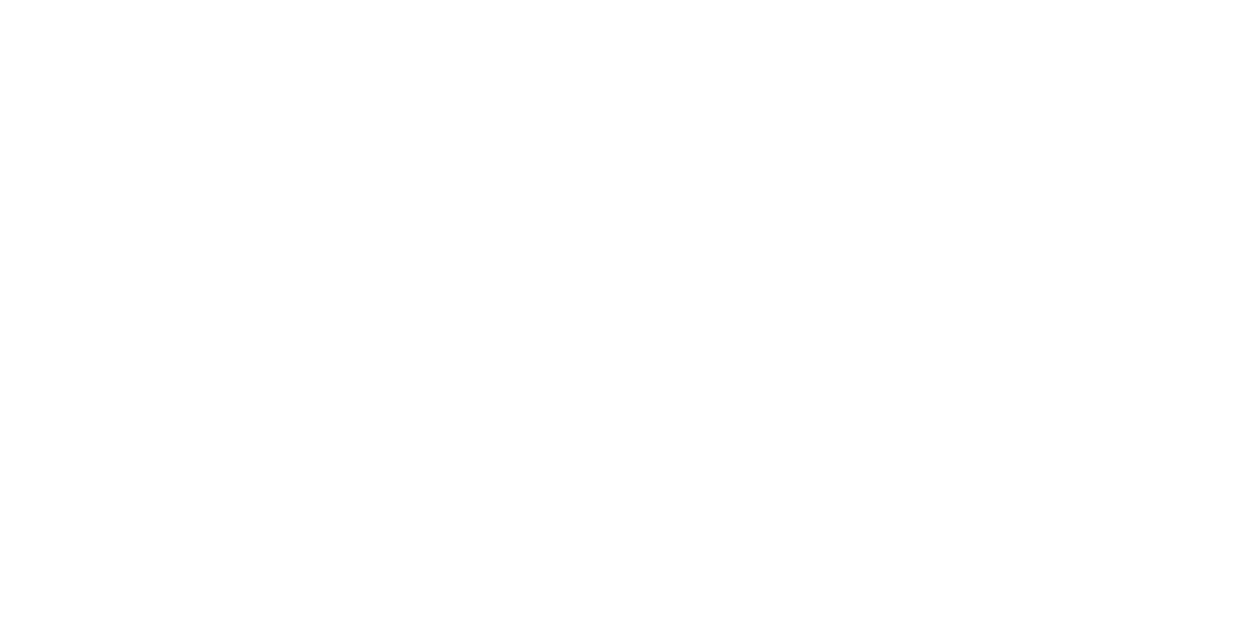

In [7]:
x = [i for i in range(20)]
y = [i*i for i in range(20)]

fig = plt.figure(figsize=(10, 5))
# ax = plt.axes(xlim=x, ylim=y) 
line, = ax.plot(x, y, lw=2, color='#0492C2')

ax.grid(True, which='major', linestyle='--', color='black', alpha=0.4)

# initialization function 
def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line, 

# lists to store x and y axis points 
xdata, ydata = [], []

# animation function 
def animate(i):
    # x, y values to be plotted 
    y = R[i] 
    
    # appending new points to x, y axes points list 
    xdata.append(i) 
    ydata.append(y) 
    line.set_data(xdata, ydata) 
    return line,

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=N, interval=20, blit=True)
# save the animation as mp4 video file 
# anim.save('random_walk.gif',writer='imagemagick')


<IPython.core.display.Javascript object>


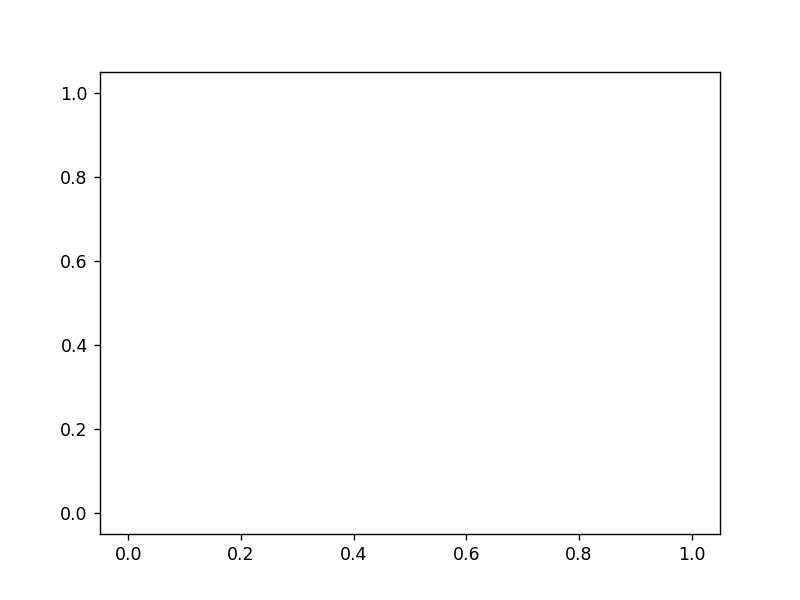

In [35]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np



x = np.random.rand(20)
y = np.random.rand(20)

fig, ax = plt.subplots()
l, = ax.plot([0, 1],[0, 1])

animate = lambda i: l.set_data(x[:i], y[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=10)

plt.show()

<IPython.core.display.Javascript object>


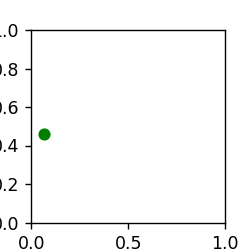

In [65]:
from matplotlib.animation import FuncAnimation


# Scatter plot
fig = plt.figure(figsize = (2, 2))
axes = fig.add_subplot(111)
axes.set_xlim(0,1)
axes.set_ylim(0,1)

point, = axes.plot([],[], 'go')

def ani(coords):
    point.set_data([np.random.rand()],[np.random.rand()])
    return point

# def frames():
#     for x_pos, y_pos in zip(x, y):
#         yield x_pos, y_pos

ani = FuncAnimation(fig, ani,  interval=500)

plt.show()

In [55]:
np.random.rand()

0.7821908571369826

<IPython.core.display.Javascript object>


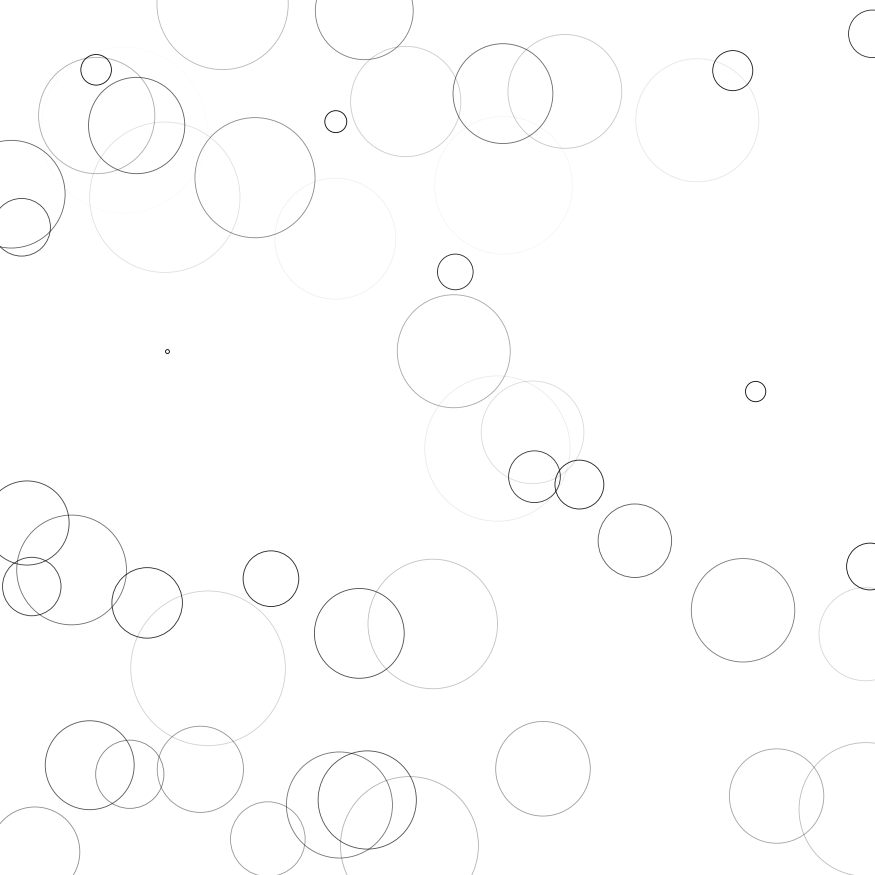

In [34]:
# Fixing random state for reproducibility
np.random.seed(19680801)


# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 1), ax.set_yticks([])

# Create rain data
n_drops = 50
rain_drops = np.zeros(n_drops, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

# Initialize the raindrops in random positions and with
# random growth rates.
rain_drops['position'] = np.random.uniform(0, 1, (n_drops, 2))
rain_drops['growth'] = np.random.uniform(50, 200, n_drops)

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = ax.scatter(rain_drops['position'][:, 0], rain_drops['position'][:, 1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors='none')


def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops

    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:, 3] = np.clip(rain_drops['color'][:, 3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    # Pick a new position for oldest rain drop, resetting its size,
    # color and growth factor.
    rain_drops['position'][current_index] = np.random.uniform(0, 1, 2)
    rain_drops['size'][current_index] = 5
    rain_drops['color'][current_index] = (0, 0, 0, 1)
    rain_drops['growth'][current_index] = np.random.uniform(50, 200)

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])


# Construct the animation, using the update function as the animation director.
animation = FuncAnimation(fig, update, interval=1)
plt.show()

<IPython.core.display.Javascript object>


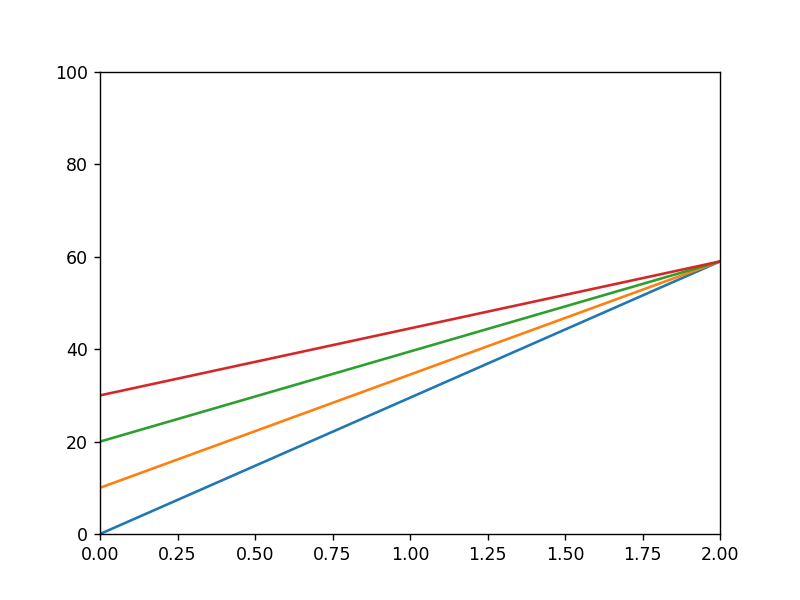

In [8]:
import matplotlib
# matplotlib.use('Qt5Agg') #use Qt5 as backend, comment this line for default backend
# %matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import animation

fig = plt.figure()

ax = plt.axes(xlim=(0, 2), ylim=(0, 100))

N = 4

lines = [plt.plot([], [])[0] for _ in range(N)] #lines to animate


# patches = lines #+ list(rectangles) #things to animate

def init():
    #init lines
    for line in lines:
        line.set_data([], [])

    return lines #return everything that must be updated

def animate(i):
    #animate lines
    for j,line in enumerate(lines):
        line.set_data([0, 2], [10 * j,i])

    return lines #return everything that must be updated

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

plt.show()

<IPython.core.display.Javascript object>


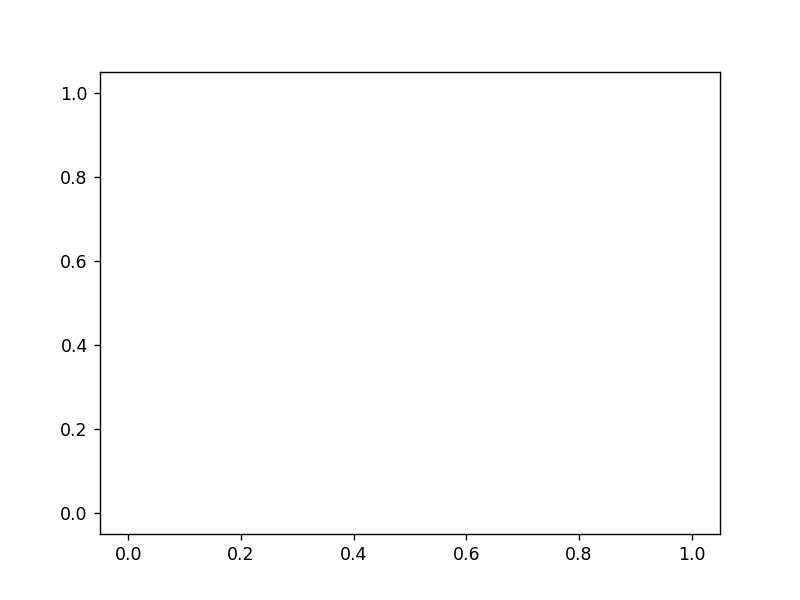

In [6]:
plt.plot([], [])[0]